# Label Shuffle Experiment for Progressive Learning

The progressive learning package utilizes representation ensembling algorithms to sequentially learn a representation for each task and ensemble both old and new representations for all future decisions. 

Here, two complementary representation ensembling algorithms based on decision forests (Lifelong Forest) and deep networks (Lifelong Network) demonstrate forward and backward knowledge transfer of tasks on the CIFAR100 dataset with the labels shuffled. The experiment reproduces the benchmarking adversarial experiment ran in the paper "A General Approach to Progressive Learning" by Vogelstein, et al (2020). https://arxiv.org/pdf/2004.12908.pdf  

### Import necessary packages and modules

In [1]:
import random
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from joblib import Parallel, delayed
from multiprocessing import Pool
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Import models from proglearn
From forest.py and network.py, we import the necessary models to perform the progressive learning. 

In [2]:
from forest import LifelongClassificationForest 
from network import LifelongClassificationNetwork

### Load CIFAR100 data 
We load the CIFAR100 dataset from Keras, and store it in a variable. The training and test partitions are concatenated into one variable called `data_x`. The data is obtained from https://keras.io/api/datasets/cifar100/ .

The label shuffle experiment randomly permutes the class labels within each task from task 2 to 9, rendering each of these tasks adversarial with regard to the first task. We show through this experiment that both L2F and L2N are invariant to class lable shuffling, and both demonstrate transfer.  

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
data_x = np.concatenate([X_train, X_test])

### Functions
Below are the functions used for training the model. 

`cross_val_data`: Splits the data into training and test sets

`run_parallel_exp`: Wrapper method for the `LF_experiment` function, also used to configure GPU

`LF_experiment`: Function that declares and trains the model, and performs validation with respect to the test data to compute the accuracy of the model at a particular iteration.  

In [4]:
def cross_val_data(data_x, data_y, num_points_per_task, total_task=10, shift=1):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]
    
    batch_per_task=5000//num_points_per_task
    sample_per_class = num_points_per_task//total_task

    for task in range(total_task):
        for batch in range(batch_per_task):
            for class_no in range(task*10,(task+1)*10,1):
                indx = np.roll(idx[class_no],(shift-1)*100)
                
                if batch==0 and class_no==0 and task==0:
                    train_x = x[indx[batch*sample_per_class:(batch+1)*sample_per_class]]
                    test_x = x[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]
                    train_y = np.random.randint(low = 0, high = total_task, size = sample_per_class)
                    test_y = np.random.randint(low = 0, high = total_task, size = total_task)
                else:
                    train_x = np.concatenate((train_x, x[indx[batch*sample_per_class:(batch+1)*sample_per_class]]), axis=0)
                    test_x = np.concatenate((test_x, x[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]), axis=0)
                    if task == 0:
                        train_y = np.concatenate((train_y, y[indx[batch*sample_per_class:(batch+1)*sample_per_class]]), axis=0)
                        test_y = np.concatenate((test_y, y[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]), axis=0)
                    else:
                        train_y = np.concatenate((train_y, np.random.randint(low = 0, high = total_task, size = sample_per_class)), axis=0)
                        test_y = np.concatenate((test_y, np.random.randint(low = 0, high = total_task, size = total_task)), axis = 0)
                
    return train_x, train_y, test_x, test_y

In [5]:
def run_parallel_exp(data_x, data_y, n_trees, model, num_points_per_task, slot=0, shift=1):
    train_x, train_y, test_x, test_y = cross_val_data(data_x, data_y, num_points_per_task, shift=shift)
    
    if model == "dnn":
        # Configure the GPU
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)
        with tf.device('/gpu:'+str(shift % 4)):
            df = LF_experiment(train_x, train_y, test_x, test_y, n_trees, shift, slot, model, num_points_per_task, acorn=12345)
        return df
    else:
        df = LF_experiment(train_x, train_y, test_x, test_y, n_trees, shift, slot, model, num_points_per_task, acorn=12345)
        return df

In [6]:
def LF_experiment(train_x, train_y, test_x, test_y, ntrees, shift, slot, model, num_points_per_task, acorn=None):
    
    #We initialize lists to store the results   
    df = pd.DataFrame()
    shifts = []
    accuracies_across_tasks = []
    learner = None
    
    if model == "dnn":
        # We initialize the convolutional neural network model for the DNN
        network = keras.Sequential()
        network.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=np.shape(train_x)[1:]))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=254, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))

        network.add(layers.Flatten())
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(2000, activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(2000, activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(units=10, activation = 'softmax'))
        
        # Declare the progressive learner model (L2N), using the neural network model as input
        learner = LifelongClassificationNetwork(network=network)
        
    elif model == "uf":
        # Declare the progressive learner model (L2F), with ntrees as a parameter
        learner = LifelongClassificationForest(n_estimators=ntrees)
                                           
    for task_ii in range(10):
        print("Starting Task {} For Fold {} For Slot {}".format(task_ii, shift, slot))
        if acorn is not None:
            np.random.seed(acorn)
        
        # If task number is 0, add task. Else, add a transformer for the task
        if task_ii == 0:
            learner.add_task(
                X = train_x[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task], 
                y = train_y[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task],
                task_id=0
            )
        else:
            learner.add_transformer(
                X = train_x[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task],
                y = train_y[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task]
            )
        
        # Make a prediction on task 0 using the trained learner on test data
        llf_task=learner.predict(
            test_x[:1000], task_id=0
            )
        
        # Calculate the accuracy of the task 0 predictions 
        acc = np.mean(
                    llf_task == test_y[:1000]
                    )
        accuracies_across_tasks.append(acc)
        shifts.append(shift)
        
        print("Accuracy Across Tasks: {}".format(accuracies_across_tasks))
            
    df['data_fold'] = shifts
    df['task'] = range(1, 11)
    df['task_1_accuracy'] = accuracies_across_tasks
    
    return df

### Define hyperparameters for the model and run model
Running the cells below will train the model. 

`model`: string storing the name of the chosen model of transformer. Choose between dnn (deep neural network) and uf (uncertainty forest).

Other hyperparameters of interest include the `num_points_per_task` and `shift_fold`, which decide the number of iterations of the algorithm. 

In [7]:
# Declare type of model
model = "uf"
num_points_per_task = 500

# Reshape the data 
if model == "uf":
    data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

# Calculate number of slots based on num_points_per_task
slot_fold = range(int(5000 // num_points_per_task))

# Declare the number of shifts
num_shifts = 7

df_list = []

In [8]:
if model == "uf":
    shift_fold = range(1,num_shifts,1) # Number of shifts
    n_trees=[10] # Number of trees in UF
    iterable = product(n_trees,shift_fold,slot_fold)
    df_list = Parallel(n_jobs=-2,verbose=1)(
        delayed(run_parallel_exp)(
                data_x, data_y, ntree, model, num_points_per_task, slot=slot, shift=shift
                ) for ntree,shift,slot in iterable
                )
    
elif model == "dnn":
    # Perform shifts in parallel
    for slot in slot_fold:
        def perform_shift(shift):
            return run_parallel_exp(data_x, data_y, 0, model, num_points_per_task, slot=slot, shift=shift)
        
        shifts = range(1, num_shifts) # Number of shifts
        with Pool(7) as p:
            df_list.append(p.map(perform_shift, shifts))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  10 | elapsed:  6.6min remaining:  1.7min
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:  6.6min finished


### Function to calculate backward transfer efficiency

The backward transfer efficiency of $f_n$ for task $t$ given $n$ 􏰁samples is 
$$BTE^t (f_n) := \mathbb{E} [R^t (f_n )/R^t (f_n)]$$

We say an algorithm (positive) backward transfers for task $t$ if and only if $BTE^t(f_n) > 1$, or if $\log BTE^t(f_n) > 0$. In other words, if 
$$BTE^t(f_n) > 1$$
then the algorithm has used data associated with new tasks to improve performance on previous tasks. 

In [9]:
def get_bte(err):
    bte = []
    
    for i in range(10):
        bte.append(err[0] / err[i])
    
    return bte  

### Plotting the backward transfer efficiency
Run cell to generate plot of backward transfer efficiency of the lifelong forest and lifelong network algorithm. We see that with both algorithms, a backward transfer efficiency greater than 1 is achieved, and the backward transfer efficiency also increases as more number of tasks are seen. 

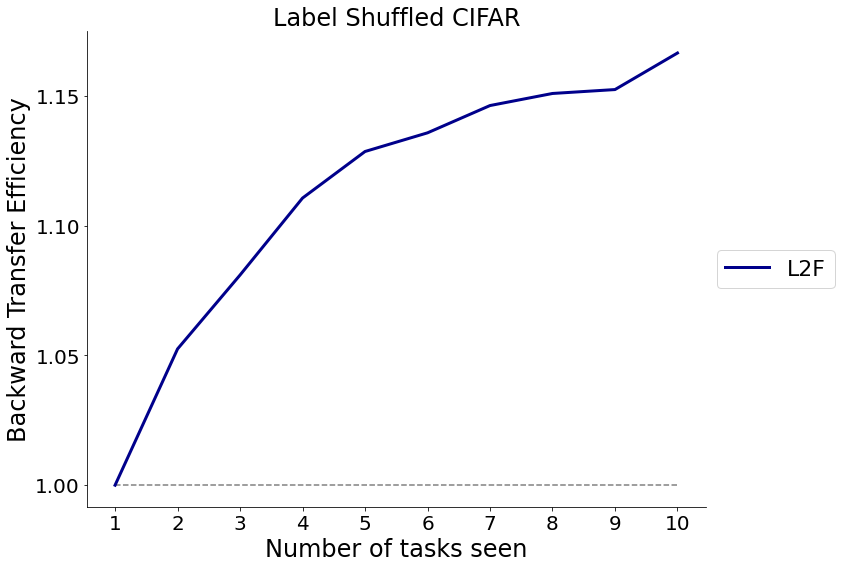

In [10]:
slots = 10 # Number of slots
shifts = 6 # Number of shifts
alg_name = ['L2N','L2F'] # Types of learners

if model == "uf":
    alg_name = [alg_name[1]]
elif model == "dnn":
    alg_name = [alg_name[0]]
    
reps = slots*shifts
btes = np.zeros((len(alg_name),10),dtype=float)

for alg_no,alg in enumerate(alg_name):
    bte_tmp = [[] for _ in range(reps)]

    count = 0   
    for shift in range(shifts):
        for slot in range(slots):
            # Get the dataframe containing the accuracies for the given shift and slot
            if model == "dnn":
                multitask_df = df_list[slot][shift]
            else :
                multitask_df = df_list[slot+shift*slots]
            err = []
            
            
            for ii in range(10):
                err.extend(
                1 - np.array(
                    multitask_df[multitask_df['task']==ii+1]['task_1_accuracy']
                )
                )
            # Calculate the bte from task 1 error
            bte = get_bte(err)
        
            bte_tmp[count].extend(bte)
            count+=1
    
    # Calculate the mean backwards transfer efficiency
    btes[alg_no] = np.mean(bte_tmp, axis = 0)

# Initialize the plot and color
clr = ["#00008B"]
c = sns.color_palette(clr, n_colors=len(clr))
fig, ax = plt.subplots(1,1, figsize=(10,8))

# Plot the results
for alg_no,alg in enumerate(alg_name):
    if alg_no<2:
        ax.plot(np.arange(1,11),btes[alg_no], c=c[alg_no], label=alg_name[alg_no], linewidth=3)
    else:
        ax.plot(np.arange(1,11),btes[alg_no], c=c[alg_no], label=alg_name[alg_no])

# Format the plot, and show result
ax.set_yticks([.9,.95, 1, 1.05,1.1,1.15,1.2])
ax.set_xticks(np.arange(1,11))
ax.tick_params(labelsize=20)
ax.set_xlabel('Number of tasks seen', fontsize=24)
ax.set_ylabel('Backward Transfer Efficiency', fontsize=24)
ax.set_title("Label Shuffled CIFAR", fontsize = 24)
ax.hlines(1,1,10, colors='grey', linestyles='dashed',linewidth=1.5)
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.tight_layout()
ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=22)
plt.show()